<center>

# Main Notebook

Dawid Rogalski

Wrocław 2023

## Introduction

This notebook can be used to reproduce all the results presented in the thesis. It is divided into three main sections:
- Training: here you can train the VGG16, VGG19, ResNet50, MobileNet and Inception models (with or without data augmentation), evaluate them and save everything to files
- Influence of image quality: here you can perform the image quality tests on the selected models, see their results and save them to files

### Loading dependencies

In [13]:
# Libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_utils as tfu
from time import time
from datetime import date
import pathlib
import albumentations as A
import random

### Setting main parameters

Paramateres set here are used throughout the entire notebook. This cell also resets the random states in NumPy, TensorFlow and default `random` library of Python. In the work three diferent seeds were used to generate independent instances of the same model: `123`, `2107` and `2603`.

In [2]:
# Parameters
EPOCHS = 100 # Number of epochs the training will have
BATCH_SIZE = 32 # Size of a batch of the datasets
IMG_SIZE = (224, 224) # Width and height of the images that the model will transform.
SEED = 123 # Random state
FPATH = 'D:/Master thesis/saved_models' # Directory in which models, training history and evaluations are saved

# Initialising the random state
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Listing available GPUs
print('GPUs available:')
display(tf.config.list_logical_devices('GPU'))

GPUs available:


[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

## Training

### Loading datasets

Loading datasets in this cell requires the folders with images to be in the same catalog as the notebook. Images in the loaded data sets are shuffled, resized and batched. Then the Kaggle DS is partitioned into the training, validation and test subsets using the set partitions and, in the end, all datasets are normalized and batched, except for the training and test subsets.

In [ ]:
# Partitions of the Kaggle DS
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading the Kaggle DS
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset', # Name of the folder with the data set stored
    validation_split=0, # We split the set manually, so it is 0
    shuffle=True, # We want to shuffle our data set
    seed=SEED, # Using the set previously SEED
    image_size=IMG_SIZE, # Loaded images are resized automatically to the set IMG_SIZE
    batch_size=None # Images are loaded without batching
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset', # Everything same as above
    validation_split=0, # No validation split, as the entire Nature DS serves as a test subset 
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Extracting name of the classes
class_names = kaggle_ds.class_names

# Number of loaded classes and images
no_classes = len(class_names)
no_images = len(kaggle_ds)

# Partitioning the Kaggle DS
train_ds, valid_ds, test_ds = tfu.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)

# Summary of the data sets
print(f'Images in subsets of Kaggle DS:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalizing and batching the datasets
kaggle_ds = kaggle_ds.map(tfu.normalize).batch(BATCH_SIZE)
train_ds = train_ds.map(tfu.normalize)
valid_ds = valid_ds.map(tfu.normalize).batch(BATCH_SIZE)
test_ds = test_ds.map(tfu.normalize)
nature_ds = nature_ds.map(tfu.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


### Augmentation

If you want to perform the augmentation, set the parameter in this cell to the proportion of the train subset you want to transform. Setting it to `0.0` will result in training the model without data augmentation

In [2]:
AUGMENTATION_PROPORTION = 0.0

This cell prepares the transformation, creates the augmented copy of the test subset (for evaluation) and performs augmentation of the training subset.

The ranges of transformation parameters were chosen based on the image quality influence tests.

Brightness, contrast and gamma transformations have `p=0.5` to keep the probabilities equal, since the list contains two instances of these transformation.

In [ ]:
from cv2 import BORDER_REPLICATE # Needed for rotation transformation

# List of transformation that can be applied to an image
transforms = [
    A.RandomBrightnessContrast(brightness_limit=(-0.6, -0.3), contrast_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(0.3, 0.6), contrast_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(-0.8, -0.4), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.4, 0.8), p=0.5),
    A.RandomGamma(gamma_limit=(0.13, 0.6), p=0.5),
    A.RandomGamma(gamma_limit=(1.67, 7.74), p=0.5),
    A.GaussNoise(var_limit=(0.001, 0.05)),
    A.GaussianBlur(blur_limit=(1, 13)),
    A.MotionBlur(blur_limit=(7, 23)),
    A.Downscale(scale_min=0.19, scale_max=0.48),
    A.Rotate(limit=(75, 285), border_mode=BORDER_REPLICATE)
]

# Creating the augmented test subset - transforming images, restoring the shapes and batching
aug_ds = test_ds\
    .map(tfu.prepare_mapping(A.OneOf(transforms, 1.0)))\
    .map(tfu.set_shapes())\
    .batch(BATCH_SIZE)

# Batching the test subset
test_ds = test_ds.batch(BATCH_SIZE)

# Augmenting the training subset - transforming images, restoring the shapes and batching
if AUGMENTATION_PROPORTION > 0:
    train_ds = train_ds\
        .map(tfu.prepare_mapping(A.OneOf(transforms, AUGMENTATION_PROPORTION)))\
        .map(tfu.set_shapes())\
        .batch(BATCH_SIZE)
else:
    train_ds = train_ds.batch(BATCH_SIZE)

### Importing the model

Depending on which model you want to train, run the cells in the chosen sections. The cells print the summary of the loaded pretrained model. The convolutional part of the model may be set to trainable or fixed by commenting or uncommenting `pretrained.trainable = False`.

#### Inception

In [21]:
# Name of the model, used in the file name and in analysing results
name = 'InceptionV3'

# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False, # We load the model without classifier part
    weights='imagenet', # Pretrained on the ImageNet data set
    input_shape=(*IMG_SIZE, 3), # We set the input_shape so that it matches our images - resolution and 3 colour channels
    pooling='avg' # Average pooling of the output is performed to get a 1D array as an input of the classifier part
)

# Displaying the summary of the loaded model
display(pretrained.summary())

# Disabling training of the convolutional part
#pretrained.trainable = False

# Creating the full model
model = tf.keras.models.Sequential(name=name)

model.add(pretrained) # The convolutional part
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED)) # A dropout layer
model.add(tf.keras.layers.Dense(no_classes, activation='softmax')) # The output layer

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### VGG16

In [17]:
# Name of the model, used in the file name and in analysing results
name = 'VGG16'

# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG16(
    include_top=False, # We load the model without classifier part
    weights='imagenet', # Pretrained on the ImageNet data set
    input_shape=(*IMG_SIZE, 3), # We set the input_shape so that it matches our images - resolution and 3 colour channels
    pooling='avg' # Average pooling of the output is performed to get a 1D array as an input of the classifier part
)

# Displaying the summary of the loaded model
display(pretrained.summary())

# Disabling training of the convolutional part
pretrained.trainable = False

# Creating the full model
model = tf.keras.models.Sequential(name=name)

model.add(pretrained) # The convolutional part
model.add(tf.keras.layers.Dense(4096, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dropout(0.5)) # A fropout layer
model.add(tf.keras.layers.Dense(4096, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dropout(0.5)) # A fropout layer
model.add(tf.keras.layers.Dense(1000, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dense(no_classes, activation='softmax')) # The output layer

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### VGG19

In [ ]:
# Name of the model, used in the file name and in analysing results
name = 'VGG19'

# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False, # We load the model without classifier part
    weights='imagenet', # Pretrained on the ImageNet data set
    input_shape=(*IMG_SIZE, 3), # We set the input_shape so that it matches our images - resolution and 3 colour channels
    pooling='avg' # Average pooling of the output is performed to get a 1D array as an input of the classifier part
)

# Displaying the summary of the loaded model
display(pretrained.summary())

# Disabling training of the convolutional part
pretrained.trainable = False

# Creating the full model
model = tf.keras.models.Sequential(name=name)

model.add(pretrained) # The convolutional part
model.add(tf.keras.layers.Dense(4096, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dropout(0.5)) # A fropout layer
model.add(tf.keras.layers.Dense(4096, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dropout(0.5)) # A fropout layer
model.add(tf.keras.layers.Dense(1000, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dense(no_classes, activation='softmax')) # The output layer

#### ResNet50

In [4]:
# Name of the model, used in the file name and in analysing results
name = 'ResNet50'

# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.ResNet50(
    include_top=False, # We load the model without classifier part
    weights='imagenet', # Pretrained on the ImageNet data set
    input_shape=(*IMG_SIZE, 3), # We set the input_shape so that it matches our images - resolution and 3 colour channels
    pooling='avg' # Average pooling of the output is performed to get a 1D array as an input of the classifier part
)

# Displaying the summary of the loaded model
display(pretrained.summary())

# Disabling training of the convolutional part
#pretrained.trainable = False

# Creating the full model
model = tf.keras.models.Sequential(name=name)

model.add(pretrained) # The convolutional part
model.add(tf.keras.layers.Dense(1000, activation='relu')) # A fully connected layer
model.add(tf.keras.layers.Dense(no_classes, activation='softmax')) # The output layer

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### MobileNet

In [5]:
# Name of the model, used in the file name and in analysing results
name = 'MobileNet'

# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False, # We load the model without classifier part
    weights='imagenet', # Pretrained on the ImageNet data set
    input_shape=(*IMG_SIZE, 3), # We set the input_shape so that it matches our images - resolution and 3 colour channels
    pooling='avg' # Average pooling of the output is performed to get a 1D array as an input of the classifier part
)

# Displaying the summary of the loaded model
display(pretrained.summary())

# Disabling training of the convolutional part
#pretrained.trainable = False

# Creating the full model
model = tf.keras.models.Sequential(name=name)

model.add(pretrained) # The convolutional part
model.add(tf.keras.layers.Dense(1024, activation='relu')) # A fully connected layr
model.add(tf.keras.layers.Dense(no_classes, activation='softmax')) # The output layer

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Compiling the model and training

This cell compiles the model using a selected optimization algorithm, loss function and metrics. The summary of the entire model is displayed.

In [5]:
# Compiling the model
model.compile(
    optimizer='adam', # The optimiation algorithm, alternatively: tf.keras.optimizers.Adam()
    loss='sparse_categorical_crossentropy', # The loss function, alternatively: tf.keras.losses.SparseCategoricalCrossentropy()
    metrics=['accuracy'] # Metrics for the evaluation process, alternatively: [tf.keras.metrics.Accuracy()]
)

# Displaying the summary of the loaded model
display(model.summary())

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 75)                75075     
                                                                 
Total params: 25,711,787
Trainable params: 25,658,667
Non-trainable params: 53,120
_________________________________________________________________


Running this cell will start the training process. The model is automatically saved for every new highest accuracy to the directory `model_name_(training_date)_i/model` in specified by `FPATH` catalog, where `i` indicates the counter of the same models trained in the same day. Keep in mind, that training time is calculated based on the starting and ending timestamps, so pausing the computations (e.h. by hibernating computer) may result in wrong training time.

In [6]:
# Caching and prefetching the data sets for better performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Saving the date of training
training_date = date.today()

# Creating name of the model for creating new directory for every trained model
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name) # Number of the models with the same name and trained on the same day
model_dir_name += str(ctr)

# Printing the name of the directory that will be created after first epoch of training
print(model_dir_name)

# Callback for the training process that will save the model when new highest validation accuracy is achieved
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model', # Directory
        monitor='val_accuracy', # Parameter to monitor
        save_best_only=True # Saving only the best model
    )
]

# Start measuring training time
t0 = time()

# Training with saving the history
history = model.fit(
    train_ds, # Training data set
    batch_size=BATCH_SIZE, # Size of batches
    epochs=EPOCHS, # Number of epochs
    validation_data=valid_ds, # Validation data set
    steps_per_epoch=len(train_ds), # Steps per epoch in trainig - number of batches in the training set
    validation_steps=len(valid_ds), # Steps per epoch in validation - number of batches in the validation set
    callbacks=callbacks
)

# Stop measuring training time
training_time = time() - t0

ResNet50_(2023-04-13)_1
Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.5168

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


219/219 [==============================] - 547s 2s/step - loss: 1.8885 - accuracy: 0.5168 - val_loss: 5.7383 - val_accuracy: 0.0175
Epoch 2/100
217/219 [============================>.] - ETA: 3s - loss: 0.6529 - accuracy: 0.8026

KeyboardInterrupt: 

### Evaluation and saving

Now the model from the best epoch is loaded to perform the evaluation of it

In [20]:
# Loading the model
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')

This cell plots the learning curves of the model and saves them to a `history.json` file in the same directory as the model.

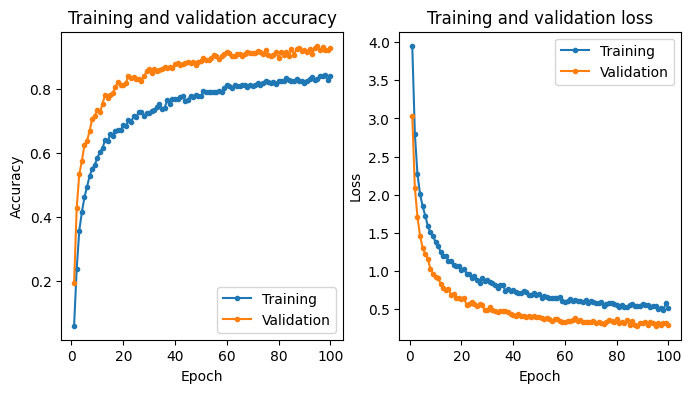

In [21]:
# Plot learning curves
tfu.plot_history(history)
plt.show()

# Save learning curves to file
tfu.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)

This cell evaluates the model on the pure test subset of Kaggle DS.

In [22]:
# Evaluation
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_loss, test_accuracy = model.evaluate(test_ds)

# Printing the results
print('Pure Kaggle DS evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 80s 439ms/step - loss: 0.3065 - accuracy: 0.9199
Kaggle set evaluation: 
Test loss: 0.30653977394104004
Test accuracy: 0.919921875


This cell computes and plots the confusion matrix for the pure test subset of Kaggle DS

In [1]:
# Empty lists for labels (targets) and predictions
targets = []
predictions = []

# Go through every batch in test_ds and append targets and predictions from this batch
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

# Compute the confusion matrix
m = tfu.confusion_matrix(predictions, targets, no_classes)

# Plot the confusion matrix
tfu.plot_confusion_matrix(m, figsize=(6,6))
plt.show()

NameError: name 'test_ds' is not defined

This cell evaluates the model on the augmented test subset of Kaggle DS.

In [ ]:
# Evaluation
aug_ds = aug_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
aug_loss, aug_accuracy = model.evaluate(aug_ds)

# Printing the results
print('Augmented Kaggle DS evaluation: ')
print(f'Test loss: {aug_loss}')
print(f'Test accuracy: {aug_accuracy}')

This cell computes and plots the confusion matrix for the augmented test subset of Kaggle DS

In [ ]:
# Empty lists for labels (targets) and predictions
targets = []
predictions = []

# Go through every batch in test_ds and append targets and predictions from this batch
for test_images, test_labels in aug_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

# Compute the confusion matrix
aug_m = tfu.confusion_matrix(predictions, targets, no_classes)

# Plot the confusion matrix
tfu.plot_confusion_matrix(aug_m, figsize=(6,6))
plt.show()

This cell evaluates the model on the Nature DS.

In [24]:
# Evaluation
nature_ds = nature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)

# Printing the results
print('Nature DS evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 381ms/step - loss: 1.0195 - accuracy: 0.7029
Nature set evaluation: 
Test loss: 1.0194560289382935
Test accuracy: 0.7028985619544983


This cell computes and plots the confusion matrix for the Nature DS

1/1 [==============================] - 4s 4s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:182: RuntimeWarning: invalid value encountered in divide
  mat[i, :] /= normalization[i]


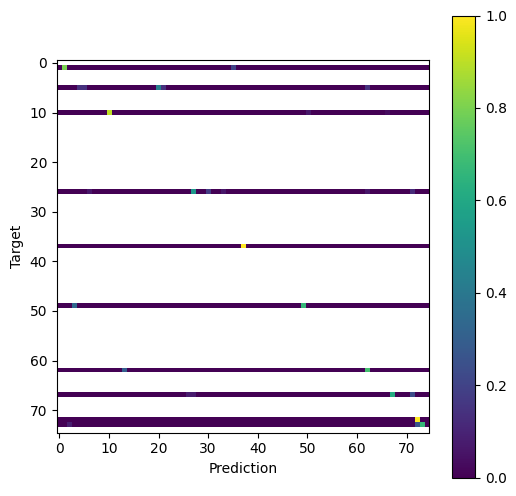

In [25]:
# Empty lists for labels (targets) and predictions
targets = []
predictions = []

# Go through every batch in test_ds and append targets and predictions from this batch
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

# Compute the confusion matrix
nature_m = tfu.confusion_matrix(predictions, targets, no_classes)

# Plot the confusion matrix
tfu.plot_confusion_matrix(m, figsize=(6,6))
plt.show()

This cells computes the average inference latency (in $ms$) by measuring the time of predicting the entire Kaggle DS and dividing it by its size.

In [26]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()

inf_time = (t1 - t0) * 1000 / 10033

314/314 [==============================] - 142s 437ms/step


This cells saves all information about the model, training parameters, results of the evaluation and additional comments to a file `info.json` in the directory of the model.

In [27]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'augmentation_proportion': AUGMENTATION_PROPORTION,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'augmented_accuracy': aug_accuracy,
    'augmented_loss': aug_loss,
    'inference_time': inf_time,
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist(),
    'augmented_confusion': aug_m.tolist(),
    'comment': ''
    }

tfu.save_json(f'{FPATH}/{model_dir_name}/info.json', info)

## Influence of image quality

This section allows you to conduct tests of the image quality influence on the model's performance. There are separate sections for every image transformation. You can test several models at the same time. 

The cell below sets the path, where the CSV files with results will be saved as `RPATH` and the suffix for filenames as `SUFFIX`. The file names will have the form of `{transformation_name}_{suffix}.csv`.

In [ ]:
RPATH = 'image quality results'
SUFFIX = 'aug0'

### Preparing functions required for transforming images

This cell defines a function that performs the test.

In [3]:
def test_transformed(model_paths, transforms, dataset, avg_amount=10):
    '''
    Performs series of tests of tensroflow models on given dataset transformed with some albumentations. For every model
    and every transformation results is averaged over `avg_amount` runs.

    ### Arguments
        `model_paths`: a list of paths to directories of models on which tests will be performed

        `transforms`: a dictionary containing these three items:

            > a list of albumentations to apply with the key `list`\n
            > a list of corresponding parameters controlling transformation with the key `parameters`\n
            > a name of a transformation with the key `name`

        `dataset`: tensorflow dataset of images on which models will be tested

        `avg_amount`: number of runs over which results will be averaged for every pair (model, transformation)

    ### Returns
        `df`: a pandas DataFrame with columns containing model's dictionary name, model's name, transformation parameter, loss and accuracy
    '''

    # Empty list for rows of DataFrame
    rows = []

    # Loop over the tested models
    for path in model_paths:
        # Load informations about the model
        info = tfu.load_json(str(path) + '/info.json')

        # Reset the random states with the seed applied to the model
        np.random.seed(info['seed'])
        tf.random.set_seed(info['seed'])
        random.seed(info['seed'])

        # Load the model
        model = tf.keras.models.load_model(str(path) + '/model')

        print(f'Testing {path.name} in progress:') # Print info about the model

        # Loop over the transformation parameters
        for itr, transform in enumerate(transforms['list']):
            print(f'\tTransform {itr+1}/{len(transforms["list"])}:') # Print progress

            # Define loss and accuracy values for averaging
            loss = 0
            accuracy = 0

            # Loop for averaging
            for itr2 in range(avg_amount):
                print(f'\t\t{itr2/avg_amount*100 : 3.0f}%', end='\r') # Print progress

                # Transform the data set
                tmp_ds = dataset\
                    .map(tfu.prepare_mapping(transform))\
                    .map(tfu.set_shapes())\
                    .batch(BATCH_SIZE)\
                    .cache().prefetch(buffer_size=tf.data.AUTOTUNE)

                # Compute loss and accuracy on the transformed data set
                tmp_loss, tmp_acc = model.evaluate(tmp_ds, verbose=False)
                
                # Accumulate the values
                loss += tmp_loss
                accuracy += tmp_acc

            print(f'\t\tLoss: {loss / avg_amount}, Accuracy: {accuracy / avg_amount}') # Print results

            # Create new row of the DataFrame
            rows.append({
                'saved_model': path.name,
                'model': model.name,
                'loss': loss / avg_amount,  # Averaging
                'accuracy': accuracy / avg_amount, # Averaging
                transforms['name']: transforms['parameters'][itr]
            })
        
    df = pd.DataFrame(rows) # Create a DataFrame
    return df

### Finding and choosing models

The following two cells allow to view all saved models and select the ones we want to test. Run the first cell to display the models stored in `FPATH` directory. Then in the second cell set the `index_list` to a list of indexes from the output of the first cell corresponding to models you want to test. You can also manually set the `selected` variable to a slice or slices of `model_paths` by uncommenting the appropriate line.

In [18]:
# Find paths of the models
model_paths = list(pathlib.Path(FPATH).glob('*'))

# Print the list
print(f"{'No.':<3}\t{'Model':<33}\t{'Test acc.':<10}\t{'Nature acc.':<10}\t{'Seed':<4}") # Header
for i, p in enumerate(model_paths):
    info = tfu.load_json(str(p) + '/info.json') # Load info about the model
    print(f"{i:<3}\t{p.name:<33}\t{info['test_accuracy']:<10.8f}\t{info['nature_accuracy']:<10.8f}\t{info['seed']:<4}") # Line

No.	Model                            	Test acc. 	Nature acc.	Seed
0  	InceptionV3_(2023-04-07)_0       	0.97460938	0.86956525	123 
1  	InceptionV3_(2023-04-08)_0       	0.97916669	0.85507250	2603
2  	InceptionV3_(2023-04-08)_1       	0.97981775	0.84057975	2107
3  	InceptionV3_aug100_(2023-05-10)_1	0.95949537	0.77536231	123 
4  	InceptionV3_aug100_(2023-05-13)_0	0.96414346	0.81159425	2107
5  	InceptionV3_aug100_(2023-05-14)_0	0.96281540	0.84057975	2603
6  	InceptionV3_aug20_(2023-05-11)_0 	0.96613550	0.86956525	123 
7  	InceptionV3_aug20_(2023-05-12)_0 	0.96879154	0.83333337	2107
8  	InceptionV3_aug20_(2023-05-15)_0 	0.96945554	0.83333337	2603
9  	InceptionV3_aug40_(2023-05-11)_2 	0.97742367	0.86956525	123 
10 	InceptionV3_aug40_(2023-05-12)_0 	0.96746349	0.84057975	2107
11 	InceptionV3_aug40_(2023-05-15)_0 	0.97078359	0.89855075	2603
12 	InceptionV3_aug60_(2023-05-11)_0 	0.97410363	0.86956525	123 
13 	InceptionV3_aug60_(2023-05-13)_0 	0.96281540	0.81159425	2107
14 	InceptionV3_aug60_(2

In [20]:
index_list = [39,40,41]

# Selecting based on the index list
selected = []
for i in index_list:
    selected.append(model_paths[i])

# Selecting based on slices
# selected = model_paths[39:42]

# Displaying the paths of the selected models
selected 

[WindowsPath('D:/Master thesis/saved_models/VGG16_(2023-03-20)_0'),
 WindowsPath('D:/Master thesis/saved_models/VGG16_(2023-04-10)_0'),
 WindowsPath('D:/Master thesis/saved_models/VGG16_(2023-04-10)_1')]

### Loading the testing dataset

This cell load the Nature DS that is used for testing. One could use test subset of Kaggle DS, but should keep in mind that models trained on different seeds have different test subsets.

In [6]:
# Loading the dataset
ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset', # Directory of the Nature DS
    validation_split=0, # No validation splitting
    shuffle=True, # Shuffling the images
    seed=SEED, # With the preset seed
    image_size=IMG_SIZE, # Resizing 
    batch_size=None # Batching is perfomed after applying transformation in the 'test_transformed' function
)

ds = ds.map(tfu.normalize)

Found 138 files belonging to 75 classes.


### Running tests

Each cell in this section is a separate test designed for separate image transformation method. The parameters are chosen arbitrary, usually cover the entire range of reasonable values. In every case `N` being the number of tested values is set to 19.

All the Albumentations used here take a range of parameters, from which they randomly choose the parameter used in transformation. To make sure, the specifically selected parameter `x` is tested, we pass the range `(x, x)`.

#### Brightness

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 6.800146150588989, Accuracy: 0.0
	Transform 2/19:
		Loss: 6.374567222595215, Accuracy: 0.06521739065647125
	Transform 3/19:
		Loss: 5.542129993438721, Accuracy: 0.10144928097724915
	Transform 4/19:
		Loss: 4.924405765533447, Accuracy: 0.21014493703842163
	Transform 5/19:
		Loss: 3.4513042688369753, Accuracy: 0.34057971835136414
	Transform 6/19:
		Loss: 2.066474366188049, Accuracy: 0.6014493107795715
	Transform 7/19:
		Loss: 1.6067184686660767, Accuracy: 0.6739130616188049
	Transform 8/19:
		Loss: 1.3720125794410705, Accuracy: 0.7101449370384216
	Transform 9/19:
		Loss: 1.1307151436805725, Accuracy: 0.7318840622901917
	Transform 10/19:
		Loss: 1.0581568479537964, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.0649362921714782, Accuracy: 0.7246376872062683
	Transform 12/19:
		Loss: 1.1784370183944701, Accuracy: 0.7028985619544983
	Transform 13/19:
		Loss: 1.4957531809806823, Accuracy: 0.6884058117866516
	Transfor

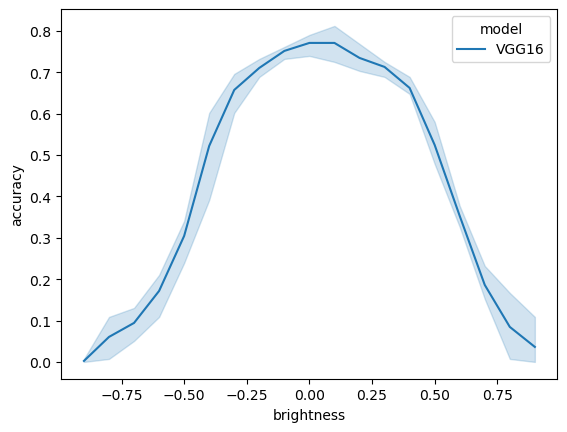

In [11]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

beta_min = -0.9 # Minimal brightness
beta_max = 0.9 # Maximal brightness
params = np.linspace(beta_min, beta_max, N) # Construcing list of parameters

transforms_list = [A.RandomBrightnessContrast( # Constructing list of transformations
    brightness_limit=(i, i), 
    contrast_limit=(0, 0), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'brightness'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Contrast

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 6.372971105575561, Accuracy: 0.0
	Transform 2/19:
		Loss: 5.436426067352295, Accuracy: 0.15942029654979706
	Transform 3/19:
		Loss: 4.505022287368774, Accuracy: 0.25362318754196167
	Transform 4/19:
		Loss: 3.47343373298645, Accuracy: 0.4057971239089966
	Transform 5/19:
		Loss: 2.647755670547485, Accuracy: 0.5579710006713867
	Transform 6/19:
		Loss: 2.11126823425293, Accuracy: 0.6014493107795715
	Transform 7/19:
		Loss: 1.6842654347419739, Accuracy: 0.6304348111152649
	Transform 8/19:
		Loss: 1.3820752024650573, Accuracy: 0.695652186870575
	Transform 9/19:
		Loss: 1.1924379825592042, Accuracy: 0.7318840622901917
	Transform 10/19:
		Loss: 1.0581568360328675, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 0.9410345077514648, Accuracy: 0.7536231875419617
	Transform 12/19:
		Loss: 0.8766845703125, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 0.8888148486614227, Accuracy: 0.760869562625885
	Transform 14/19:
	

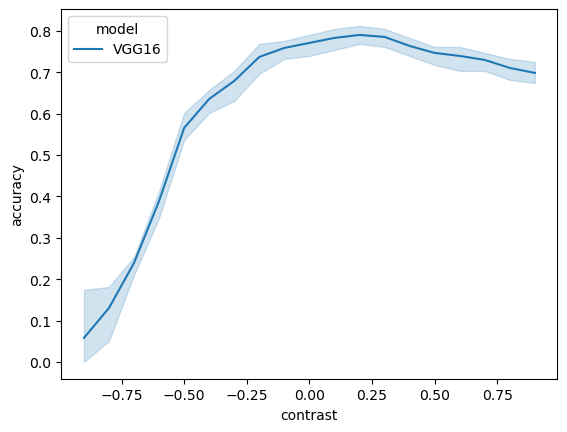

In [12]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

alpha_min = -0.9 # Minimal contrast
alpha_max = 0.9 # Maximal contrast
params = np.linspace(alpha_min, alpha_max, N) # Construcing list of parameters

transforms_list = [A.RandomBrightnessContrast( # Constructing list of transformations
    brightness_limit=(0, 0), 
    contrast_limit=(i, i), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'contrast'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Gaussian noise

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 1.1449602246284485, Accuracy: 0.7181159496307373
	Transform 2/19:
		Loss: 1.2056280612945556, Accuracy: 0.6963768243789673
	Transform 3/19:
		Loss: 1.2863049030303955, Accuracy: 0.6637681365013123
	Transform 4/19:
		Loss: 1.4018603682518005, Accuracy: 0.6507246613502502
	Transform 5/19:
		Loss: 1.4954611778259277, Accuracy: 0.6550724864006042
	Transform 6/19:
		Loss: 1.6335113286972045, Accuracy: 0.6442029237747192
	Transform 7/19:
		Loss: 1.7893579125404357, Accuracy: 0.6195652484893799
	Transform 8/19:
		Loss: 2.0627383470535277, Accuracy: 0.5586956441402435
	Transform 9/19:
		Loss: 2.4214276552200316, Accuracy: 0.4862318873405457
	Transform 10/19:
		Loss: 2.8449216365814207, Accuracy: 0.40434783399105073
	Transform 11/19:
		Loss: 3.2778809309005736, Accuracy: 0.34855073094367983
	Transform 12/19:
		Loss: 3.7020198822021486, Accuracy: 0.291304349899292
	Transform 13/19:
		Loss: 4.091601228713989, Accuracy: 0.265942025

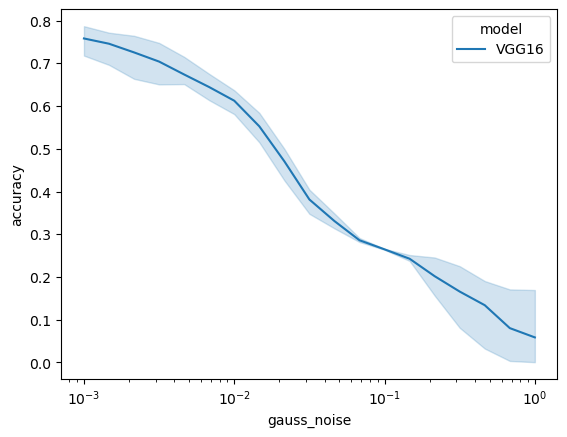

In [13]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

var_min = -3 # Minimal exponent of variance 
var_max = 0 # Maximal exponent of variance
params = np.logspace(var_min, var_max, N) # Construcing list of parameters

transforms_list = [A.GaussNoise( # Constructing list of transformations
    var_limit=(i, i), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_noise'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Gamma

For some reason the `RandomGamma` Albumentation is internally dividing gamma parameter by 100 so we set the values 100 times larger.

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 7.437325191497803, Accuracy: 0.0
	Transform 2/19:
		Loss: 7.32642617225647, Accuracy: 0.0
	Transform 3/19:
		Loss: 6.988480520248413, Accuracy: 0.014492753893136978
	Transform 4/19:
		Loss: 6.283290958404541, Accuracy: 0.12318840622901917
	Transform 5/19:
		Loss: 5.338818645477295, Accuracy: 0.21739131212234497
	Transform 6/19:
		Loss: 4.610175704956054, Accuracy: 0.28985506296157837
	Transform 7/19:
		Loss: 3.348735213279724, Accuracy: 0.42028987407684326
	Transform 8/19:
		Loss: 1.9416816473007201, Accuracy: 0.5942029356956482
	Transform 9/19:
		Loss: 1.1812163472175599, Accuracy: 0.7536231875419617
	Transform 10/19:
		Loss: 1.0581568360328675, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.2531979203224182, Accuracy: 0.7246376872062683
	Transform 12/19:
		Loss: 1.9300244450569153, Accuracy: 0.6521739363670349
	Transform 13/19:
		Loss: 3.7474039077758787, Accuracy: 0.2971014678478241
	Transform 14/19:
		Loss:

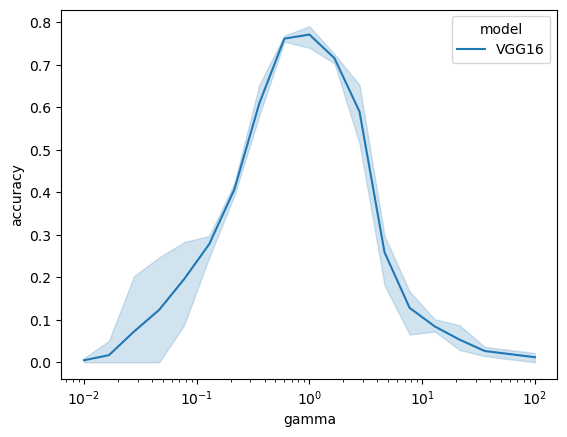

In [14]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

gamma_min = 0 # Minimal exponent of gamma, actual value is -2
gamma_max = 4 # Maximal exponent of gamma, actual value i 2
params = np.logspace(gamma_min, gamma_max, N) # Construcing list of parameters

transforms_list = [A.RandomGamma( # Constructing list of transformations
    gamma_limit=(i, i), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'gamma'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)
df[transforms['name']] /= 100 # see the explanation above

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Gaussian blur

For the Gaussian blur, kernel size must be of type `int` and odd.

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 1.0581568360328675, Accuracy: 0.739130437374115
	Transform 2/19:
		Loss: 1.494960641860962, Accuracy: 0.7028985619544983
	Transform 3/19:
		Loss: 1.8264554500579835, Accuracy: 0.6449275612831116
	Transform 4/19:
		Loss: 2.2126951932907106, Accuracy: 0.6086956858634949
	Transform 5/19:
		Loss: 2.4915536403656007, Accuracy: 0.5507246255874634
	Transform 6/19:
		Loss: 2.941579580307007, Accuracy: 0.49275362491607666
	Transform 7/19:
		Loss: 3.5697437047958376, Accuracy: 0.39855071902275085
	Transform 8/19:
		Loss: 4.345075607299805, Accuracy: 0.30434784293174744
	Transform 9/19:
		Loss: 5.172083616256714, Accuracy: 0.23188406229019165
	Transform 10/19:
		Loss: 5.873430967330933, Accuracy: 0.2028985619544983
	Transform 11/19:
		Loss: 6.398702383041382, Accuracy: 0.14492753148078918
	Transform 12/19:
		Loss: 6.768237686157226, Accuracy: 0.10144928097724915
	Transform 13/19:
		Loss: 7.066009950637818, Accuracy: 0.050724640488

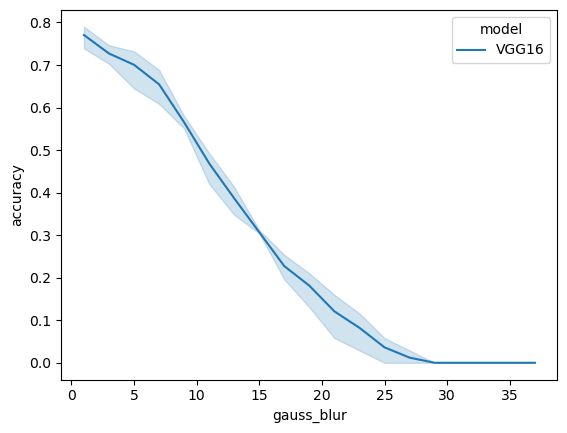

In [15]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

gauss_kernel_min = 1 # Minimal kernel of Gaussian blur
gauss_kernel_max = 37 # Maximal kernel of Gaussian blur
params = np.linspace(gauss_kernel_min, gauss_kernel_max, N, dtype=int) # Construcing list of parameters

transforms_list = [A.GaussianBlur( # Constructing list of transformations
    blur_limit=(i, i), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_blur'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)
df[transforms['name']] /= 100 # see the explanation above

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Motion blur

For the motion blur, kernel size must be of type `int` and odd.

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 1.2357672452926636, Accuracy: 0.732608699798584
	Transform 2/19:
		Loss: 1.6424551248550414, Accuracy: 0.6688405990600585
	Transform 3/19:
		Loss: 2.595124530792236, Accuracy: 0.534782600402832
	Transform 4/19:
		Loss: 3.654106545448303, Accuracy: 0.4021739184856415
	Transform 5/19:
		Loss: 4.285089612007141, Accuracy: 0.33115942776203156
	Transform 6/19:
		Loss: 4.928311729431153, Accuracy: 0.24492753595113753
	Transform 7/19:
		Loss: 5.701356554031372, Accuracy: 0.18188406080007552
	Transform 8/19:
		Loss: 5.884178590774536, Accuracy: 0.16159420609474182
	Transform 9/19:
		Loss: 6.369091892242432, Accuracy: 0.12753623202443123
	Transform 10/19:
		Loss: 6.808482503890991, Accuracy: 0.10289855152368546
	Transform 11/19:
		Loss: 6.815227746963501, Accuracy: 0.09420289918780327
	Transform 12/19:
		Loss: 7.055293321609497, Accuracy: 0.08695652335882187
	Transform 13/19:
		Loss: 7.347453594207764, Accuracy: 0.05869565196335

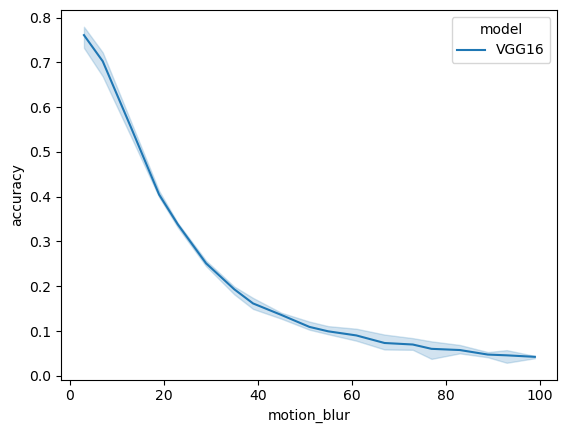

In [16]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

motion_kernel_min = 3 # Minimal kernel of motion blur
motion_kernel_max = 100 # Maximal kernel of motion blur
params = np.linspace(motion_kernel_min, motion_kernel_max, N, dtype=int) # Construcing list of parameters
params[params % 2 == 0] -= 1 # Asserting odd values

transforms_list = [A.MotionBlur( # Constructing list of transformations
    blur_limit=(i, i), 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'motion_blur'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Downscale

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 7.634906196594239, Accuracy: 0.0
	Transform 2/19:
		Loss: 11.76826229095459, Accuracy: 0.0
	Transform 3/19:
		Loss: 17.389259910583498, Accuracy: 0.0
	Transform 4/19:
		Loss: 23.803492164611818, Accuracy: 0.0
	Transform 5/19:
		Loss: 21.609726333618163, Accuracy: 0.0
	Transform 6/19:
		Loss: 13.415132331848145, Accuracy: 0.0
	Transform 7/19:
		Loss: 10.884685516357422, Accuracy: 0.0
	Transform 8/19:
		Loss: 9.176169776916504, Accuracy: 0.007246376946568489
	Transform 9/19:
		Loss: 8.512533378601074, Accuracy: 0.014492753893136978
	Transform 10/19:
		Loss: 8.319790744781494, Accuracy: 0.07971014827489853
	Transform 11/19:
		Loss: 7.966822242736816, Accuracy: 0.12318840622901917
	Transform 12/19:
		Loss: 8.567989349365234, Accuracy: 0.014492753893136978
	Transform 13/19:
		Loss: 8.257421588897705, Accuracy: 0.007246376946568489
	Transform 14/19:
		Loss: 7.182797479629516, Accuracy: 0.021739130839705467
	Transform 15/19:
	

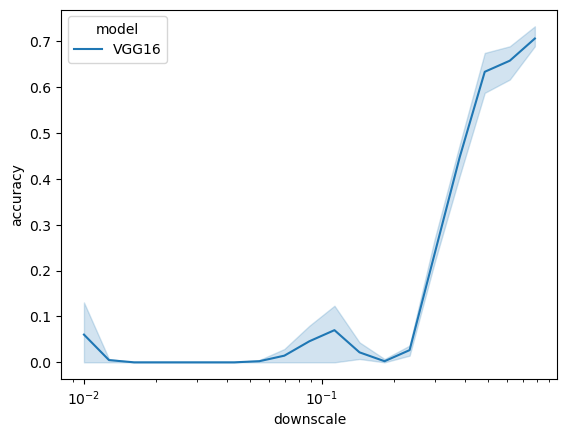

In [17]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

scale_min = -2 # Minimal exponent of scale
scale_max = 0 # Maximal exponent of scale
params = np.logspace(scale_min, scale_max, N) # Construcing list of parameters

transforms_list = [A.Downscale( # Constructing list of transformations
    scale_min=i,
    scale_max=i, 
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'downscale'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")

#### Rotation

Testing VGG16_(2023-03-20)_0 in progress:
	Transform 1/19:
		Loss: 1.0581568360328675, Accuracy: 0.739130437374115
	Transform 2/19:
		Loss: 1.2539705514907837, Accuracy: 0.7101449370384216
	Transform 3/19:
		Loss: 1.2326792478561401, Accuracy: 0.6739130616188049
	Transform 4/19:
		Loss: 1.1526939749717713, Accuracy: 0.6666666865348816
	Transform 5/19:
		Loss: 1.196072256565094, Accuracy: 0.6666666865348816
	Transform 6/19:
		Loss: 1.260536003112793, Accuracy: 0.6521739363670349
	Transform 7/19:
		Loss: 1.4040843486785888, Accuracy: 0.5942029356956482
	Transform 8/19:
		Loss: 1.5444196581840515, Accuracy: 0.5724637508392334
	Transform 9/19:
		Loss: 1.7991717219352723, Accuracy: 0.4855072498321533
	Transform 10/19:
		Loss: 1.904591679573059, Accuracy: 0.5
	Transform 11/19:
		Loss: 1.9354681491851806, Accuracy: 0.5
	Transform 12/19:
		Loss: 2.262594532966614, Accuracy: 0.5144927501678467
	Transform 13/19:
		Loss: 2.1791801691055297, Accuracy: 0.49275362491607666
	Transform 14/19:
		Loss: 

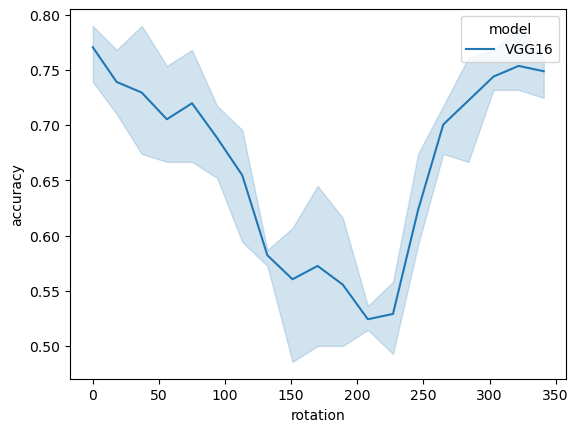

In [18]:
# Preparing transformations
N = 19 # Number of tested parameters
M = 10 # Number of runs for taking the average

angle_min = 0 # Minimal exponent of scale
angle_max = 360 # Maximal exponent of scale, endpoint is omitted as rotation by 0 and 360 is the same
params = np.linspace(angle_min, angle_max, N, dtype=int, endpoint=False) # Construcing list of parameters

from cv2 import BORDER_REPLICATE # Extrapolation method
transforms_list = [A.Rotate( # Constructing list of transformations
    limit=(i, i),
    border_mode=BORDER_REPLICATE,
    always_apply=True) for i in params]

transforms = { # Constructing the dictionary passed to the 'test_transformed' function
    'list': transforms_list,
    'parameters': params,
    'name': 'rotation'
}

# Conducting tests
df = test_transformed(selected, transforms, ds, M)

# Showing the results
sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

# Saving the results
df.to_csv(f"{RPATH}/{transforms['name']}_{SUFFIX}.csv")